In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 


In [5]:
sub_0001 = pd.read_csv("/mnt/disk1/aiotlab/hieupc/New_CBraMod/BIDS/BIG_BIDS_Statistic/sub-0001_scans.tsv", sep ="\t")

In [7]:
participant = pd.read_csv("/mnt/disk1/aiotlab/hieupc/New_CBraMod/BIDS/BIG_BIDS_Statistic/participants.tsv" , sep = "\t")

In [8]:
participant

,participant_id,age,sex,group
0,sub-0001,NaN,female,NaN
1,sub-0002,58.0,female,NaN
2,sub-0003,33.0,female,NaN
3,sub-0004,33.0,female,NaN
4,sub-0005,NaN,female,NaN
...,...,...,...,...
6076,sub-6077,NaN,NaN,NaN
6077,sub-6078,NaN,NaN,NaN
6078,sub-6079,NaN,NaN,NaN
6079,sub-6080,NaN,NaN,NaN


In [12]:
# Ép cột age sang numeric, lỗi sẽ thành NaN
participant["age"] = pd.to_numeric(participant["age"], errors="coerce")



In [23]:
participant_age = participant.dropna(subset=["age"])
print(f"recorded age {len(participant_age)} , n/a {6081 - len(participant_age)}")

recorded age 2186 , n/a 3895


In [14]:
age = participant_age['age']
print(f"mean {np.mean(age)} std {np.std(age)} , min {np.min(age)} , max {np.max(age)} , ...")

mean 45.886093321134496 std 18.08241574095681 , min 1.0 , max 104.0 , ...


In [15]:
print(f"median {np.median(age)}")
print(f"Q1 {np.percentile(age, 25)}, Q3 {np.percentile(age, 75)}")

median 46.0
Q1 34.0, Q3 60.0


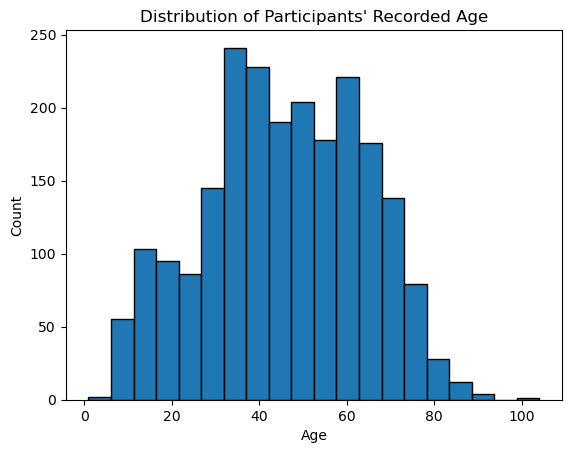

In [22]:
plt.hist(age, bins=20, edgecolor="black")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Participants' Recorded Age")
plt.show()

In [17]:
participant_sex = participant.dropna(subset=["sex"])

In [20]:
sex = participant_sex['sex']
print(f"number of sex counted {len(sex)}, n/a: {6081 - len(sex)}")

number of sex counted 5104, n/a: 977


In [40]:
# Thống kê số lượng từng giới tính
counts = sex.value_counts()

print("Sex distribution:")
print(counts)

# Tính tỉ lệ %
print("\nSex percentage:")
print((counts / 6081 * 100).round(2))

napercent = 977 / 6081 *100
print(f"unspecified {napercent}")

Sex distribution:
female    3748
male      1356
Name: sex, dtype: int64

Sex percentage:
female    61.63
male      22.30
Name: sex, dtype: float64
unspecified 16.066436441374773


In [32]:
import os
import glob
import json
import pandas as pd

# Define the BIDS root directory
bids_root = "/mnt/disk1/aiotlab/hieupc/New_CBraMod/BIDS/Small_BIDS_Non_Match"

# Find all JSON files matching the pattern sub-*_task-rest*_eeg.json
json_files = glob.glob(
    os.path.join(bids_root, "**", "sub-*_task-rest*_eeg.json"),
    recursive=True
)

records = []

# Process each JSON file
for f in json_files:
    try:
        with open(f, "r", encoding="utf-8") as jf:  # Added encoding for robustness
            meta = json.load(jf)

        # Check if "RecordingDuration" exists and is valid
        if "RecordingDuration" in meta and isinstance(meta["RecordingDuration"], (int, float)):
            duration = meta["RecordingDuration"]
            subject = os.path.basename(f).split("_")[0]  # Extract subject ID (e.g., sub-0003)
            run = [part for part in os.path.basename(f).split("_") if part.startswith("run-")]
            run_id = run[0] if run else None  # Handle cases with no run ID

            records.append({
                "subject": subject,
                "run": run_id,
                "file": os.path.basename(f),
                "duration": duration
            })
        else:
            print(f"Warning: 'RecordingDuration' missing or invalid in {f}")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in {f}: {e}")
    except Exception as e:
        print(f"Error processing {f}: {e}")

# Check if any records were collected
if records:
    rec_df = pd.DataFrame(records)

    # Group by subject and sum durations
    dur_by_subject = rec_df.groupby("subject")["duration"].sum().reset_index()

    # Print total recording duration per subject
    print("\nTotal recording duration per subject (seconds):")
    print(dur_by_subject)

    # Print overall statistics
    print("\nOverall statistics by subject:")
    print(dur_by_subject["duration"].describe())

    # Print total duration in hours
    total_hours = dur_by_subject["duration"].sum() / 3600
    print(f"\nTotal duration (hours): {total_hours:.2f}")
else:
    print("No valid records found.")


Total recording duration per subject (seconds):
       subject  duration
0     sub-0001   107.998
1     sub-0002   269.998
2     sub-0003    97.998
3     sub-0004    36.998
4     sub-0005    90.998
...        ...       ...
2242  sub-2243   110.998
2243  sub-2244   119.998
2244  sub-2245   360.998
2245  sub-2246    93.998
2246  sub-2247   100.998

[2247 rows x 2 columns]

Overall statistics by subject:
count    2247.000000
mean      144.261017
std       168.943174
min         0.998000
25%        88.998000
50%       114.998000
75%       153.998000
max      3121.998000
Name: duration, dtype: float64

Total duration (hours): 90.04


In [34]:
import pandas as pd
import glob
import os

# Define the BIDS root directory
bids_root = "/mnt/disk1/aiotlab/hieupc/New_CBraMod/BIDS/Small_BIDS_Non_Match"

# Find all scans.tsv files
scan_files = glob.glob(os.path.join(bids_root, "**", "sub-*_scans.tsv"), recursive=True)

all_scans = []

# Process each scans.tsv file
for f in scan_files:
    try:
        # Read the TSV file, assuming tab-separated and ignoring comments
        df = pd.read_csv(f, sep="\t", comment="#", encoding="utf-8")
        
        # Check if 'acq_time' column exists
        if "acq_time" in df.columns:
            # Convert acq_time to datetime, invalid parsing will result in NaT
            df["acq_time"] = pd.to_datetime(df["acq_time"], errors="coerce")
            
            # Drop rows where acq_time is NaT (invalid datetime)
            df = df.dropna(subset=["acq_time"])
            
            # Add subject ID for tracking (optional, but useful for debugging)
            subject = os.path.basename(f).split("_")[0]  # Extract subject ID (e.g., sub-0003)
            df["subject"] = subject
            
            # Append only relevant columns
            if not df.empty:
                all_scans.append(df[["subject", "acq_time"]])
            else:
                print(f"Warning: No valid acq_time entries in {f}")
        else:
            print(f"Warning: 'acq_time' column missing in {f}")
    except pd.errors.EmptyDataError:
        print(f"Error: {f} is empty or invalid")
    except Exception as e:
        print(f"Error reading {f}: {e}")

# Check if any valid scans were collected
if all_scans:
    # Concatenate all DataFrames
    scans_df = pd.concat(all_scans, ignore_index=True)

    # Add year and quarter columns
    scans_df["year"] = scans_df["acq_time"].dt.year
    scans_df["quarter"] = scans_df["acq_time"].dt.to_period("Q")

    # Group and count by year
    year_counts = scans_df["year"].value_counts().sort_index()
    print("\nRecord count by year:")
    print(year_counts)

    # Group and count by quarter
    quarter_counts = scans_df["quarter"].value_counts().sort_index()
    print("\nRecord count by quarter:")
    print(quarter_counts)

    # Optional: Print total number of valid records
    print(f"\nTotal valid records: {len(scans_df)}")
else:
    print("No valid scans found.")


Record count by year:
2024     874
2025    1373
Name: year, dtype: int64

Record count by quarter:
2024Q3    317
2024Q4    557
2025Q1    559
2025Q2    648
2025Q3    166
Freq: Q-DEC, Name: quarter, dtype: int64

Total valid records: 2247


In [ ]:
Total recording duration per subject (seconds):
       subject  duration
0     sub-0001   109.998
1     sub-0002   295.998
2     sub-0003   125.998
3     sub-0004    88.998
4     sub-0005   177.998
...        ...       ...
6046  sub-6077   780.995
6047  sub-6078   936.995
6048  sub-6079   988.995
6049  sub-6080  1614.995
6050  sub-6081  1040.995

[6051 rows x 2 columns]

Overall statistics by subject:
count      6051.000000
mean        695.933188
std        5527.242768
min           0.998000
25%         106.998000
50%         147.998000
75%         262.998000
max      224587.986000
Name: duration, dtype: float64

Total duration (hours): 1169.75

In [41]:
print(f"{695.933188/60}")

11.598886466666666


In [ ]:
ecord count by year:
year
2019       9
2020      17
2021     413
2022     627
2024    2258
2025    2895
Name: count, dtype: int64

Record count by quarter:
quarter
2019Q3       5
2019Q4       4
2020Q4      17
2021Q1       2
2021Q2       3
2021Q3     164
2021Q4     244
2022Q1     230
2022Q2     387
2022Q3      10
2024Q1     870
2024Q2     513
2024Q3     318
2024Q4     557
2025Q1     602
2025Q2     691
2025Q3    1602
Freq: Q-DEC, Name: count, dtype: int64

Total valid records: 6219